In [1]:
import xgboost as xgb
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from shap_analysis import SHAPAnalyzer, function_map
import optuna

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df = pd.read_csv("thesis_cleaned_transformed_histone_dataset_categorical(H3K23me1).tsv", sep="\t")

X = df.drop(columns = ['Gene Expression (FPKM)_log'])
y = df['Gene Expression (FPKM)_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
df.describe()

,H2A.2,H3K4me1,H2A.13,H3K4me3,H3K36me3,H4K5Ac,H2A.Z.11,expression_category,H3K27me3_log,H3K9Ac_log,...,chh_percentage_log,H4K20me1_log,chg_percentage_log,H2A.W.7_log,H3K9me1_log,H2A.W.6_log,H2A.Z.9_log,Gene Expression (FPKM)_log,H3K23me1_log,H3K9me2_log
count,25045.000000,25045.000000,25045.000000,25045.000000,25045.000000,25045.000000,25045.000000,25045.000000,25045.000000,25045.000000,...,25045.000000,25045.000000,25045.000000,25045.000000,25045.000000,25045.000000,25045.000000,25045.000000,25045.000000,25045.000000
mean,22.487637,18.662098,22.645528,22.954304,21.921118,22.677444,24.592780,0.893791,2.854554,3.047952,...,-0.887799,2.547871,-1.260523,2.292738,2.523749,2.183695,3.209084,0.520849,2.699327,2.471488
std,8.988551,4.046783,7.754602,6.275447,9.523958,7.770371,13.080275,0.308111,0.700863,0.488758,...,0.756476,0.305476,1.824959,0.263927,0.240522,0.271012,0.724068,3.907551,0.489856,0.228255
min,3.441818,7.066029,4.954294,7.672183,6.304647,3.165609,4.525310,0.000000,1.529310,1.874085,...,-9.210340,1.509911,-9.210340,1.588998,1.624565,1.310268,0.403433,-9.210340,0.997268,1.631872
25%,14.896367,15.891959,16.342547,18.790774,12.469411,17.439247,13.632224,1.000000,2.373926,2.664295,...,-1.206924,2.350665,-1.520274,2.132600,2.373572,2.020727,2.744207,-0.370919,2.387442,2.331826
50%,21.670355,18.817420,22.167338,22.381741,21.973320,21.961251,21.939322,1.000000,2.577287,2.982506,...,-0.939229,2.545956,-1.039179,2.259224,2.527070,2.150947,3.306844,1.834196,2.713249,2.447736
75%,29.532407,21.483595,28.533691,26.230946,30.526152,27.139932,33.652347,1.000000,3.207587,3.372260,...,-0.646768,2.740591,-0.605741,2.410691,2.672450,2.305004,3.757631,2.933862,3.019540,2.581106
max,50.498810,30.839472,46.644002,49.965170,46.318101,58.375773,71.995265,1.000000,4.952035,4.762968,...,2.748008,3.707023,4.098032,4.095839,3.642703,3.906534,4.690665,7.677224,4.501172,3.563349


In [3]:
X_train.columns

Index(['H2A.2', 'H3K4me1', 'H2A.13', 'H3K4me3', 'H3K36me3', 'H4K5Ac',
       'H2A.Z.11', 'expression_category', 'H3K27me3_log', 'H3K9Ac_log',
       'cpg_percentage_log', 'H3K9K14Ac_log', 'H3Ac_log', 'chh_percentage_log',
       'H4K20me1_log', 'chg_percentage_log', 'H2A.W.7_log', 'H3K9me1_log',
       'H2A.W.6_log', 'H2A.Z.9_log', 'H3K23me1_log', 'H3K9me2_log'],
      dtype='object')

# No Feature Removal

In [ ]:
# Helper function to help evaluate the model results of the optuna study 
def evaluate_model(X_train, X_test, y_train, y_test, params=None, optuna_study=None):
    """
    Evaluate the model either using the provided parameters or the Optuna study's best trial.
    
    Parameters:
    - X_train (pd.DataFrame): Training feature data.
    - X_test (pd.DataFrame): Test feature data.
    - y_train (pd.Series): Training target data.
    - y_test (pd.Series): Test target data.
    - params (dict): Parameters for the XGBoost model. If None, use `optuna_study`.
    - optuna_study (optuna.Study): Optuna study object containing the best trial.
    
    Returns:
    - model: Trained XGBoost model.
    - total_score (float): The evaluation score based on SHAP analysis.
    - result_summary (dict): Summary of matches and mismatches.
    - results_df (pd.DataFrame): Detailed SHAP results for features.
    """
    # Determine parameters: Use the best trial from Optuna if no parameters are provided
    if optuna_study is not None and params is None:
        params = optuna_study.best_trial.params
        params.update({
            'booster': 'gbtree',
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'tree_method': 'hist',
            'device': 'cuda'
        })

    # Prepare the data
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Train the model
    model = xgb.train(
        params, 
        dtrain, 
        num_boost_round=100, 
        evals=[(dtest, 'validation')],
        early_stopping_rounds=10, 
        verbose_eval=False
    )

    # SHAP analysis
    background_indices = np.random.choice(X_train.shape[0], size=200, replace=False)
    background_sample = X_train.iloc[background_indices]

    sample_indices = np.random.choice(X_test.shape[0], size=200, replace=False)
    sample = X_test.iloc[sample_indices]

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Use the SHAPAnalyzer to calculate metrics
    analyzer = SHAPAnalyzer(X_test, shap_values, function_map)
    analyzer.calculate_high_value_shap_means()

    results_df, total_score, result_summary = analyzer.get_results()

    print(f"Results Summary: {result_summary}")

    return model, total_score, result_summary, results_df


[I 2025-03-15 22:22:50,095] A new study created in memory with name: no-name-7bb70cd2-de1c-4df4-9216-2f15439a9e5f



--- Performing LOO for feature H3K23me1_log ---



[22:22:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[I 2025-03-15 22:22:53,382] Trial 0 finished with value: 0.875 and parameters: {'learning_rate': 0.021578205053792883, 'max_depth': 12, 'subsample': 0.4660067458089235, 'gamma': 0.6063508487723404, 'colsample_bytree': 0.5718262009480242, 'lambda': 0.3731645313994502, 'alpha': 8.848864228887665}. Best is trial 0 with value: 0.875.
[22:22:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[I 2025-03-15 22:22:56,627] Trial 1 finished with value: 0.875 and parameters: {'learning_rate': 0.019193302925622022, 'max_de


--- Evaluating model with feature H3K23me1_log added back ---



[22:25:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Results Summary: {'Match': 14, 'Mismatch': 2, 'No Evaluation': 1}


[22:25:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


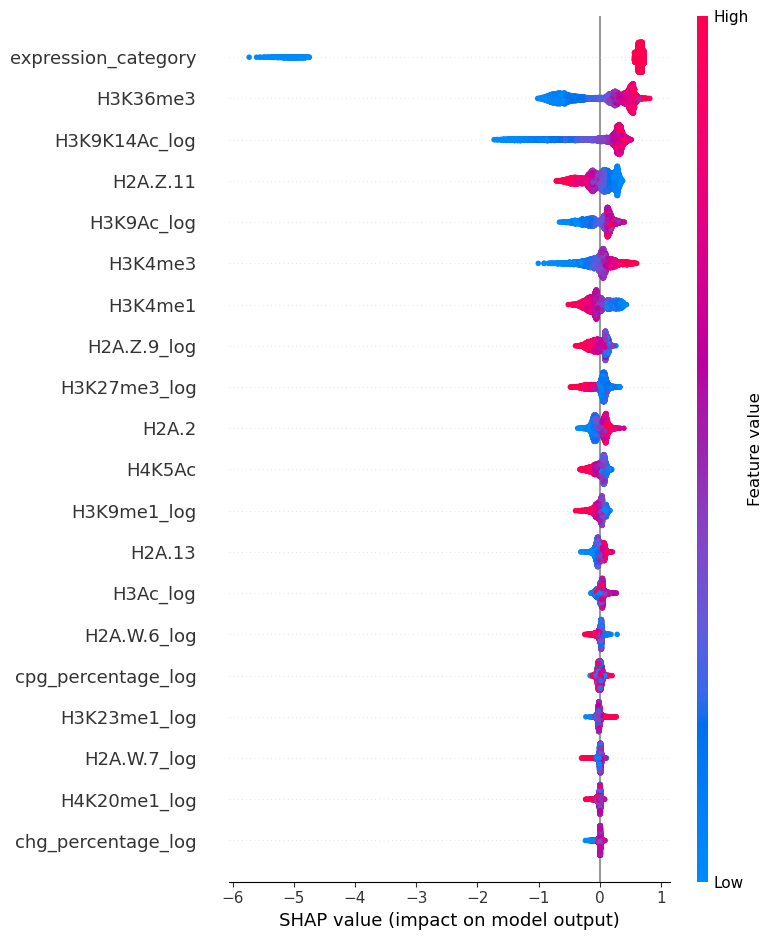

Feature: H3K23me1_log, Known Function: Unknown, Result: No Evaluation

--- Overall Accuracy ---
Total Matches: 14
Total Mismatches: 2
Accuracy: 0.88


In [ ]:
# No feature removal at the cross validation step
import optuna
import shap
import xgboost as xgb

# Assuming X_train, X_test, y_train, y_test, function_map, and SHAPAnalyzer (and evaluate_model) are defined

def run_leave_one_out_feature(feature_to_leave_out, X_train, X_test, y_train, y_test, function_map):
    print(f"\n--- Performing LOO for feature {feature_to_leave_out} ---\n")
    
    # Remove the specified feature from training and test data
    reduced_X_train = X_train.drop(columns=[feature_to_leave_out])
    reduced_X_test = X_test.drop(columns=[feature_to_leave_out])
    
    # Define the objective function for Optuna
    def optuna_objective(trial):
        params = {
            'booster': 'gbtree',
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'tree_method': 'hist',
            'device': 'cuda',
            'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.05),
            'max_depth': trial.suggest_int("max_depth", 10, 30),
            'subsample': trial.suggest_float("subsample", 0.4, 1.0),
            'gamma': trial.suggest_float("gamma", 0.0, 1.0),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
            'lambda': trial.suggest_float("lambda", 1e-3, 15),
            'alpha': trial.suggest_float("alpha", 1e-3, 15),
        }
        
        dtrain = xgb.DMatrix(reduced_X_train, label=y_train)
        dvalid = xgb.DMatrix(reduced_X_test, label=y_test)
        
        model = xgb.train(params, dtrain, num_boost_round=100,
                          evals=[(dvalid, 'validation')],
                          early_stopping_rounds=10,
                          verbose_eval=False)
        
        # Compute SHAP values for the reduced dataset
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(reduced_X_test)
        
        # Analyze SHAP values using your SHAPAnalyzer class
        analyzer = SHAPAnalyzer(reduced_X_test, shap_values, function_map)
        analyzer.calculate_high_value_shap_means()
        results_df, total_score, result_summary = analyzer.get_results()
        
        # Calculate accuracy from match/mismatch counts
        total_matches = result_summary.get("Match", 0)
        total_mismatches = result_summary.get("Mismatch", 0)
        accuracy = total_matches / (total_matches + total_mismatches) if (total_matches + total_mismatches) > 0 else 0
        
        trial.set_user_attr("result_summary", result_summary)
        trial.set_user_attr("results_df", results_df)
        
        return accuracy

    # Create and run the Optuna study
    study = optuna.create_study(direction='maximize')
    study.optimize(optuna_objective, n_trials=40)
    
    # Evaluate the final model with the left-out feature added back in
    print(f"\n--- Evaluating model with feature {feature_to_leave_out} added back ---\n")
    model, total_score, result_summary, results_df = evaluate_model(
        X_train, X_test, y_train, y_test, optuna_study=study
    )
    
    # Generate and display the SHAP beeswarm plot using the final model
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, plot_type="dot")
    
    # Extract and display the SHAP analysis for the left-out feature
    feature_result = results_df[results_df["Features"] == feature_to_leave_out]
    if not feature_result.empty:
        match_result = feature_result["Result"].values[0]
        try:
            index = function_map["Features"].index(feature_to_leave_out)
            known_function = function_map["Known Function"][index]
        except ValueError:
            known_function = "Not Found"
        print(f"Feature: {feature_to_leave_out}, Known Function: {known_function}, Result: {match_result}")
    
    total_matches = result_summary.get("Match", 0)
    total_mismatches = result_summary.get("Mismatch", 0)
    overall_accuracy = total_matches / (total_matches + total_mismatches) if (total_matches + total_mismatches) > 0 else 0
    
    print("\n--- Overall Accuracy ---")
    print(f"Total Matches: {total_matches}")
    print(f"Total Mismatches: {total_mismatches}")
    print(f"Accuracy: {overall_accuracy:.2f}")
    
    return model, total_score, result_summary, results_df

# Run the refactored procedure for a specific feature
feature_to_leave_out = "H3K23me1_log"
model, total_score, result_summary, results_df = run_leave_one_out_feature(
    feature_to_leave_out, X_train, X_test, y_train, y_test, function_map
)

In [7]:
results_df

,Features,Mean SHAP Value (High),Known Function,Function Value,Accuracy Score,Result
0,H3K4me1,-0.216661,Activating,1.0,-0.216661,Mismatch
1,H3K4me3,0.242274,Activating,1.0,0.242274,Match
2,H3K36me3,0.529296,Activating,1.0,0.529296,Match
3,H4K5Ac,-0.127964,Activating,1.0,-0.127964,Mismatch
4,H3K27me3_log,-0.179779,Repressive,-1.0,0.179779,Match
5,H3K9Ac_log,0.174336,Activating,1.0,0.174336,Match
6,cpg_percentage_log,-0.012242,Repressive,-1.0,0.012242,Match
7,H3K9K14Ac_log,0.339308,Activating,1.0,0.339308,Match
8,H3Ac_log,0.027383,Activating,1.0,0.027383,Match
9,chh_percentage_log,-0.003462,Repressive,-1.0,0.003462,Match


# Feature Removal at the optimization step

In [12]:
def feature_selection_with_optuna(X_train, X_test, y_train, y_test, function_map):
    remaining_features = X_train.columns.tolist()
    selected_features = []

    def optuna_objective(trial, X_train, X_test, y_train, y_test):
        params = {
            'booster': 'gbtree',
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'tree_method': 'hist',
            'device': 'cuda',
            'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.05),
            'max_depth': trial.suggest_int("max_depth", 10, 30),
            'subsample': trial.suggest_float("subsample", 0.4, 1.0),
            'gamma': trial.suggest_float("gamma", 0.0, 1.0),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
            'lambda': trial.suggest_float("lambda", 1e-3, 15),
            'alpha': trial.suggest_float("alpha", 1e-3, 15),
    }

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_test, label=y_test)

        model = xgb.train(params, dtrain, num_boost_round=100,
                          evals=[(dvalid, 'validation')],
                          early_stopping_rounds=10,
                          verbose_eval=False)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        analyzer = SHAPAnalyzer(X_test, shap_values, function_map)
        analyzer.calculate_high_value_shap_means()

        results_df, total_score, result_summary = analyzer.get_results()
        total_mismatches = result_summary.get("Mismatch", 0)
        total_matches = result_summary.get("Match", 0)
        accuracy = total_matches / (total_matches + total_mismatches) if (total_matches + total_mismatches) > 0 else 0

        # Define the objective score
        alpha = 1.0  # Weight for accuracy
        beta = 1.0   # Weight for mismatch count
        objective_score = alpha * accuracy
        
        trial.set_user_attr("result_summary", result_summary)
        trial.set_user_attr("results_df", results_df)
        
        return objective_score

    while remaining_features:
        print(f"Remaining Features: {remaining_features}")
        
        # Run Optuna for the current subset of features
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: optuna_objective(trial, 
                                                      X_train[remaining_features], 
                                                      X_test[remaining_features], 
                                                      y_train, y_test), 
                       n_trials=40)
        
        best_params = study.best_params
        print(f"Best Parameters: {best_params}")

        # Evaluate model with the current subset
        reduced_X_train = X_train[remaining_features]
        reduced_X_test = X_test[remaining_features]

        model, total_score, result_summary, results_df = evaluate_model(
            reduced_X_train, reduced_X_test, y_train, y_test, optuna_study=study
)

        mismatch_features = results_df[results_df["Result"] == "Mismatch"]

        if mismatch_features.empty:
            selected_features = remaining_features
            break

        # Sort mismatching features and remove the highest impact one
        mismatch_to_remove = mismatch_features.sort_values(
            by="Mean SHAP Value (High)", ascending=False
        ).iloc[0]["Features"]

        print(f"Removing mismatch feature: {mismatch_to_remove}")
        remaining_features.remove(mismatch_to_remove)

    return selected_features, study


[I 2025-03-16 00:40:29,743] A new study created in memory with name: no-name-31927b8f-f7a8-4c5d-8d77-8908c259dd5f


Remaining Features: ['H2A.2', 'H3K4me1', 'H2A.13', 'H3K4me3', 'H3K36me3', 'H4K5Ac', 'H2A.Z.11', 'expression_category', 'H3K27me3_log', 'H3K9Ac_log', 'cpg_percentage_log', 'H3K9K14Ac_log', 'H3Ac_log', 'chh_percentage_log', 'H4K20me1_log', 'chg_percentage_log', 'H2A.W.7_log', 'H3K9me1_log', 'H2A.W.6_log', 'H2A.Z.9_log', 'H3K9me2_log']


[00:40:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[I 2025-03-16 00:40:37,078] Trial 0 finished with value: 0.75 and parameters: {'learning_rate': 0.025760806678578045, 'max_depth': 28, 'subsample': 0.6041705995292198, 'gamma': 0.1819486726064109, 'colsample_bytree': 0.808151918285958, 'lambda': 3.5877213499516634, 'alpha': 4.576781593298883}. Best is trial 0 with value: 0.75.
[00:40:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[I 2025-03-16 00:40:40,537] Trial 1 finished with value: 0.8125 and parameters: {'learning_rate': 0.03676544422127957, 'max_depth

Best Parameters: {'learning_rate': 0.0017459649703050173, 'max_depth': 22, 'subsample': 0.9028058075711989, 'gamma': 0.08439212448441602, 'colsample_bytree': 0.9684183135750764, 'lambda': 12.472148083942466, 'alpha': 14.133364338481261}


[00:43:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[I 2025-03-16 00:43:16,118] A new study created in memory with name: no-name-1062103a-0da3-40bd-9092-ac5475f8835a


Results Summary: {'Match': 14, 'Mismatch': 2}
Removing mismatch feature: H4K5Ac
Remaining Features: ['H2A.2', 'H3K4me1', 'H2A.13', 'H3K4me3', 'H3K36me3', 'H2A.Z.11', 'expression_category', 'H3K27me3_log', 'H3K9Ac_log', 'cpg_percentage_log', 'H3K9K14Ac_log', 'H3Ac_log', 'chh_percentage_log', 'H4K20me1_log', 'chg_percentage_log', 'H2A.W.7_log', 'H3K9me1_log', 'H2A.W.6_log', 'H2A.Z.9_log', 'H3K9me2_log']


[00:43:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[I 2025-03-16 00:43:19,241] Trial 0 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.039388964181876186, 'max_depth': 25, 'subsample': 0.450217874146849, 'gamma': 0.9594257469663254, 'colsample_bytree': 0.5908034832173432, 'lambda': 4.826012794574038, 'alpha': 6.110124871737623}. Best is trial 0 with value: 0.7333333333333333.
[00:43:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[I 2025-03-16 00:43:24,049] Trial 1 finished with value: 0.8666666666666667 and parameters: {'learning

Best Parameters: {'learning_rate': 0.01174414854406369, 'max_depth': 15, 'subsample': 0.7710527063824422, 'gamma': 0.2849765560992923, 'colsample_bytree': 0.8427515325346311, 'lambda': 4.175237969354362, 'alpha': 12.125515734316956}


[00:46:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[I 2025-03-16 00:46:02,822] A new study created in memory with name: no-name-f68eef8b-2388-4255-956c-77106c81fd2d


Results Summary: {'Match': 14, 'Mismatch': 1}
Removing mismatch feature: H3K4me1
Remaining Features: ['H2A.2', 'H2A.13', 'H3K4me3', 'H3K36me3', 'H2A.Z.11', 'expression_category', 'H3K27me3_log', 'H3K9Ac_log', 'cpg_percentage_log', 'H3K9K14Ac_log', 'H3Ac_log', 'chh_percentage_log', 'H4K20me1_log', 'chg_percentage_log', 'H2A.W.7_log', 'H3K9me1_log', 'H2A.W.6_log', 'H2A.Z.9_log', 'H3K9me2_log']


[00:46:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[I 2025-03-16 00:46:07,141] Trial 0 finished with value: 0.7142857142857143 and parameters: {'learning_rate': 0.04360574601702239, 'max_depth': 23, 'subsample': 0.9608962118617744, 'gamma': 0.40702355193044903, 'colsample_bytree': 0.8090202757461602, 'lambda': 6.859570165097636, 'alpha': 13.054724579172031}. Best is trial 0 with value: 0.7142857142857143.
[00:46:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[I 2025-03-16 00:46:09,864] Trial 1 finished with value: 0.9285714285714286 and parameters: {'learni

Best Parameters: {'learning_rate': 0.010268507901070017, 'max_depth': 20, 'subsample': 0.8196143407837533, 'gamma': 0.9246142430135235, 'colsample_bytree': 0.7720990640357672, 'lambda': 4.8121453718177225, 'alpha': 0.6392161428448467}


[00:48:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Results Summary: {'Match': 14}

--- Evaluating model with unknown feature H3K23me1_log added back ---



[00:48:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Results Summary: {'Match': 14, 'No Evaluation': 1}


[00:48:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1707159369174/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


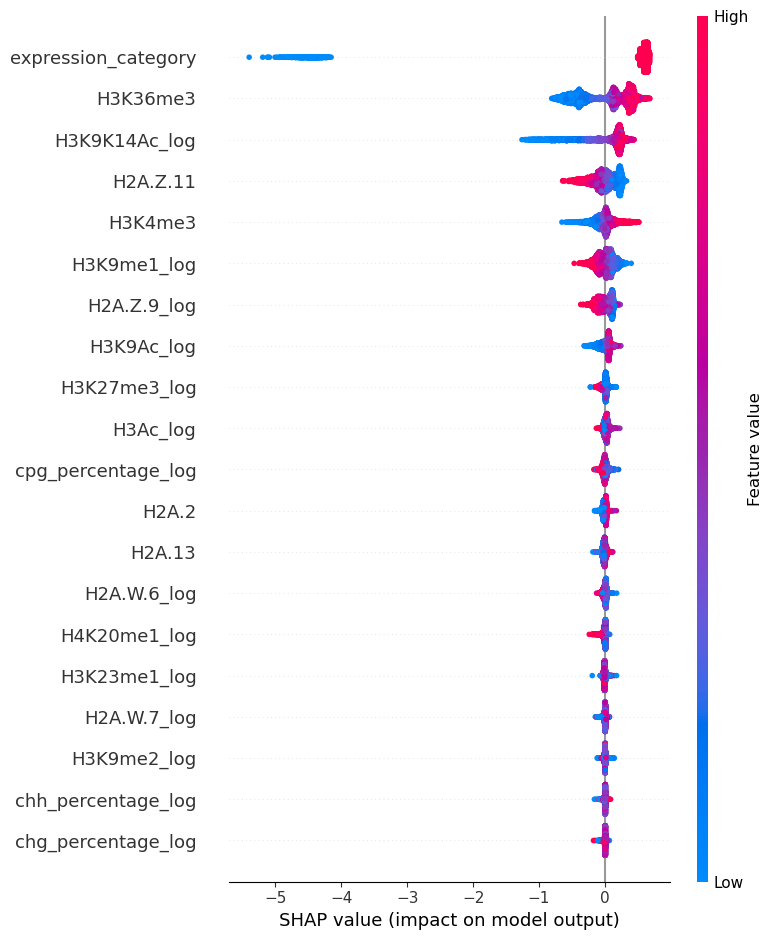

Feature: H3K23me1_log, Known Function: Unknown, Result: No Evaluation
Unknown Feature: H3K23me1_log, Result: No Evaluation

--- SHAP Analysis Results for Unknown Feature ---
Total Score: 1.2127604519482702
Total Matches: 14
Total Mismatches: 0
Accuracy: 1.00


In [16]:
# Define the unknown feature you want to test
unknown_feature = "H3K23me1_log"

# Remove the unknown feature from training and test sets
reduced_X_train = X_train.drop(columns=[unknown_feature])
reduced_X_test = X_test.drop(columns=[unknown_feature])

# Run the helper function for feature selection on the reduced dataset
selected_features, study = feature_selection_with_optuna(
    reduced_X_train, reduced_X_test, y_train, y_test, function_map
)

# Add back the unknown feature for the final evaluation
final_X_train = X_train[selected_features + [unknown_feature]]
final_X_test = X_test[selected_features + [unknown_feature]]

print(f"\n--- Evaluating model with unknown feature {unknown_feature} added back ---\n")

# Evaluate the model using your evaluate_model function
model, total_score, result_summary, results_df = evaluate_model(
    final_X_train, final_X_test, y_train, y_test, optuna_study=study
)

# Generate and display the SHAP beeswarm plot using the final model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(final_X_test)
shap.summary_plot(shap_values, final_X_test, plot_type="dot")

# Extract and display the SHAP analysis for the left-out feature
feature_result = results_df[results_df["Features"] == feature_to_leave_out]
if not feature_result.empty:
    match_result = feature_result["Result"].values[0]
    try:
        index = function_map["Features"].index(feature_to_leave_out)
        known_function = function_map["Known Function"][index]
    except ValueError:
        known_function = "Not Found"
    print(f"Feature: {feature_to_leave_out}, Known Function: {known_function}, Result: {match_result}")

# Extract the SHAP analysis results for the unknown feature
feature_result = results_df[results_df["Features"] == unknown_feature]

if not feature_result.empty:
    match_result = feature_result["Result"].values[0]
    print(f"Unknown Feature: {unknown_feature}, Result: {match_result}")

# Calculate overall accuracy from SHAP analysis
total_matches = result_summary.get("Match", 0)
total_mismatches = result_summary.get("Mismatch", 0)
total_features = total_matches + total_mismatches
accuracy = total_matches / total_features if total_features > 0 else 0

print("\n--- SHAP Analysis Results for Unknown Feature ---")
print(f"Total Score: {total_score}")
print(f"Total Matches: {total_matches}")
print(f"Total Mismatches: {total_mismatches}")
print(f"Accuracy: {accuracy:.2f}")


In [17]:
results_df

,Features,Mean SHAP Value (High),Known Function,Function Value,Accuracy Score,Result
0,H3K4me3,0.156980,Activating,1.0,0.156980,Match
1,H3K36me3,0.411690,Activating,1.0,0.411690,Match
2,H3K27me3_log,-0.058805,Repressive,-1.0,0.058805,Match
3,H3K9Ac_log,0.070888,Activating,1.0,0.070888,Match
4,cpg_percentage_log,-0.031808,Repressive,-1.0,0.031808,Match
5,H3K9K14Ac_log,0.237045,Activating,1.0,0.237045,Match
6,H3Ac_log,0.004374,Activating,1.0,0.004374,Match
7,chh_percentage_log,-0.002153,Repressive,-1.0,0.002153,Match
8,H4K20me1_log,-0.044292,Repressive,-1.0,0.044292,Match
9,chg_percentage_log,-0.006668,Repressive,-1.0,0.006668,Match
